<div style="float:right; padding-top: 15px; padding-right: 15px">
    <div>
        <a href="https://whiteboxml.com">
            <img src="https://whiteboxml.com/static/img/logo/black_bg_white.svg" width="250">
        </a>
    </div>
</div>

## 0. python imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## 1. data loading

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = \
    fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

4423680/4422102 [==============================] - 0s 0us/step


## 2. data exploration

In [4]:
def plot_images_sample(images: np.array,
                       labels: np.array,
                       samples: int,
                       figsize: tuple = (8, 8)):
    """
    samples some images from dataset and
    plot a grid of images with its
    corresponding labels
    """

    h = int(np.sqrt(samples))
    w = h

    f, axarr = plt.subplots(h, w, figsize=figsize)

    for i in range(h):
        for j in range(w):
            index = np.random.choice(len(images))
            axarr[i, j].imshow(images[index])
            axarr[i, j].set_title(f"class: {labels[index]}")
            axarr[i, j].axis('off')

    plt.tight_layout()
    plt.show()

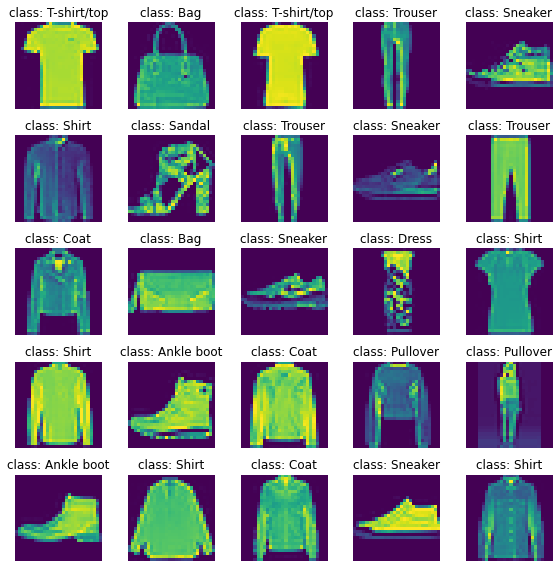

In [5]:
plot_images_sample(train_images, 
                   [class_names[i] for i in train_labels], 
                   samples=25)

## 3. preprocessing

In [6]:
train_images, test_images = train_images / 255, test_images / 255

In [7]:
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

## 4. modeling

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [9]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

## 5. model training

In [12]:
history = model.fit(train_images, 
                    train_labels, 
                    batch_size=64, 
                    epochs=2, 
                    validation_data=(test_images, test_labels))

Epoch 1/2
938/938 [==============================] - 27s 28ms/step - loss: 0.3136 - accuracy: 0.8868 - val_loss: 0.3271 - val_accuracy: 0.8814
Epoch 2/2
938/938 [==============================] - 25s 26ms/step - loss: 0.2935 - accuracy: 0.8945 - val_loss: 0.3208 - val_accuracy: 0.8848


In [13]:
def plot_training(history, metrics: list = ('loss',), figsize: tuple = (12, 5)):
    """
    plots training selected metrics for every batch
    """
    epochs = range(1, len(history.history[metrics[0]]) + 1)

    fig, ax_arr = plt.subplots(1, len(metrics), figsize=figsize)

    if not isinstance(ax_arr, np.ndarray):
        ax_arr = np.array(ax_arr).reshape(1, )

    for i, metric in enumerate(metrics):
        ax_arr[i].plot(epochs, history.history[metric], color='k', linestyle='solid', label=metric, linewidth=2)
        ax_arr[i].plot(epochs, history.history[f"val_{metric}"], color='r', linestyle='dotted',
                       label=f'validation {metric}')
        ax_arr[i].set_ylabel(metric)
        ax_arr[i].set_xlabel('epochs')
        ax_arr[i].grid()
        ax_arr[i].legend()
    plt.show()

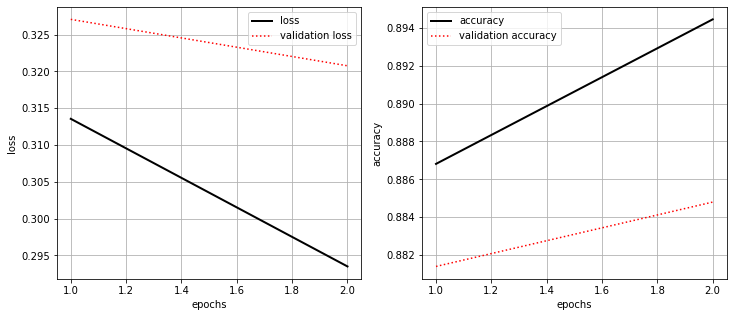

In [14]:
plot_training(history, metrics=['loss', 'accuracy'])

## 6. model evaluation

In [15]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

313/313 [==============================] - 2s 6ms/step - loss: 0.3208 - accuracy: 0.8848


In [16]:
test_accuracy

0.8848000168800354

## 7. making predictions

In [17]:
proba_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [18]:
predictions = proba_model.predict(test_images)

In [19]:
def plot_image_pred(images: np.ndarray,
                    labels: np.ndarray,
                    preds: np.ndarray,
                    indexes: list,
                    class_names: list = None, 
                    figsize: tuple = (8, 4)):
            
        for index in indexes:
        
            predicted_probas = preds[index]
            true_index = labels[index]
            predicted_index = np.argmax(predicted_probas)
            
            if class_names:
                true_class = class_names[true_index]
                predicted_class = class_names[predicted_index]

            fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figsize)

            axes[0].imshow(images[index]);
            axes[0].axis('off')
            axes[0].set_title(f"predicted class: {predicted_class if class_names else predicted_index}", 
                              color='blue' if true_index == predicted_index else 'red')

            axes[1].barh(class_names if class_names else [str(i) for i in range(len(predicted_probas))],
                         predicted_probas, 
                         color='black')
            axes[1].get_children()[predicted_index].set_color('red')
            axes[1].get_children()[true_index].set_color('blue')
            axes[1].set_xlim(0, 1)
            axes[1].set_title("class probabilities")
            axes[1].set_xlabel("probability")
            axes[1].set_ylabel("class name")

            plt.tight_layout()
            plt.show()

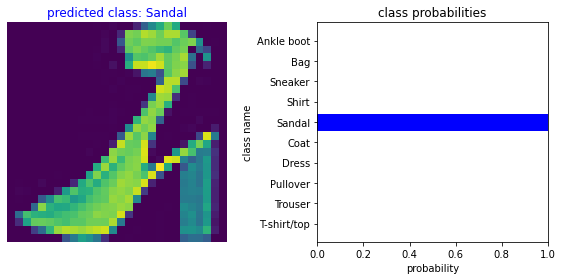

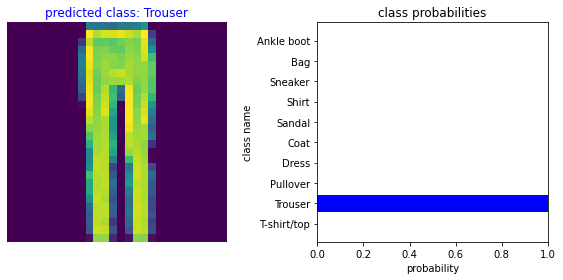

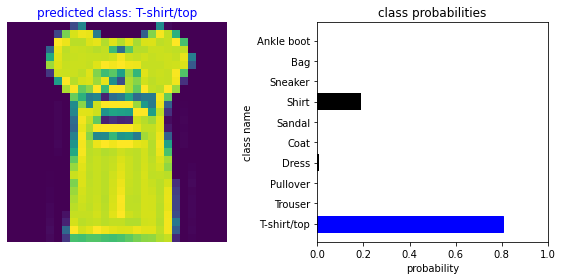

In [23]:
plot_image_pred(test_images, test_labels, predictions, indexes=[1002, 2002, 9002], class_names=class_names)

## 8. using the model

In [54]:
img = test_images[1]

In [55]:
img.shape

(28, 28, 1)

In [56]:
img[np.newaxis].shape

(1, 28, 28, 1)

In [57]:
pred = proba_model.predict(img[np.newaxis])
pred

array([[4.5473515e-03, 8.4896645e-10, 9.9450254e-01, 1.7461693e-07,
        4.0507707e-04, 3.9465809e-12, 5.4491067e-04, 8.4160645e-14,
        1.5758046e-09, 5.1533634e-12]], dtype=float32)

In [58]:
np.argmax(pred)

2

## 9. using dataset api

In [59]:
def build_dataset():
    
    # load data
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    # transform into tf.data.Dataset
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    
    # normalize pixel values
    train_ds = train_ds.map(lambda x, y: (tf.cast(x, dtype=tf.float32) / 255.0, y))
    test_ds = test_ds.map(lambda x, y: (tf.cast(x, dtype=tf.float32) / 255.0, y))
    
    # shuffle
    train_ds = train_ds.shuffle(10000)
    
    # batch
    train_ds = train_ds.batch(32)
    test_ds = test_ds.batch(32)
    
    return train_ds, test_ds

In [60]:
train_ds, test_ds = build_dataset()

<div style="padding-top: 25px; float: right">
    <div>    
        <i>&nbsp;&nbsp;© Copyright by</i>
    </div>
    <div>
        <a href="https://whiteboxml.com">
            <img src="https://whiteboxml.com/static/img/logo/black_bg_white.svg" width="125">
        </a>
    </div>
</div>